# Loan Performance Prediction
This notebook shows my work of building a regression model to predict whether the mortgage foreclosed (FORECLOSED)

In [253]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler,scale
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [254]:
df = pd.read_csv("TRAIN.csv")
dfTEST = pd.read_csv("TEST.csv")
## TRAIN
dfR = pd.read_csv("dfR.csv",index_col=0) # # (164575, 19)
## TEST
dfF = pd.read_csv("dfTEST.csv",index_col=0)

In [255]:
dfR.FORECLOSED.value_counts()

False    162328
True       2247
Name: FORECLOSED, dtype: int64

## Add Filtered Features

In [256]:
to_drop3 = ['FPD','MDATE','CLTV','CBCSAO','MIT','NB','BCSAO','MSA','ZIP','MIP',]
dfR['CLDS']=df.CLDS

In [257]:
MDATE = df.MDATE.astype('string')
for i,mdate in enumerate(MDATE):
    if len(mdate)<6:
        MDATE[i] = '0'+mdate
    else:
        MDATE[i] = mdate
MDATE = pd.to_datetime(MDATE,format="%m%Y")
MDATE = (MDATE-min(MDATE))/np.timedelta64(1, 'Y')
# sns.barplot(y=MDATE, x='FORECLOSED',data=df)

In [258]:
dfR['NB']=df.NB
dfR['NB']=dfR.NB.fillna(dfR.NB.median())

In [259]:
dfR['BCSAO']=df.BCSAO
dfR['BCSAO']=dfR.BCSAO.fillna(dfR.BCSAO.mean())

In [260]:
MSA=df.MSA.replace(0,df.loc[df.MSA>0,'MSA'].min())
dfR['MSA']=np.log(MSA)
# sns.barplot(y=MSA, x='FORECLOSED',data=df)

In [261]:
dfR['ZIP'] = df.ZIP
# sns.barplot(y='ZIP', x='FORECLOSED',data=df)

In [262]:
# sns.histplot(df.MIP)
dfR['MIP'] = df.MIP.fillna(dfR.NB.mean())
# sns.barplot(y='MIP', x='FORECLOSED',data=df)

In [263]:
y_nmonths = dfR.pop('NMONTHS')
y1 = dfR.pop('FORECLOSED')
dfR['FORECLOSED']=y1
dfR.columns

Index(['MRP', 'CHANNEL', 'SELLER', 'ORATE', 'OUPB', 'OLTERM', 'ODATE', 'LA',
       'LOTV', 'DTI', 'FTHBI', 'LP', 'PTYPE', 'NUNITS', 'OCCSTAT', 'STATE',
       'RMI', 'CLDS', 'NB', 'BCSAO', 'MSA', 'ZIP', 'MIP', 'FORECLOSED'],
      dtype='object')

In [264]:
## Drop If repeated features
corrF =  dfR.iloc[:,:-1].corr().abs()
upper = corrF.where(np.triu(np.ones(corrF.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print('drop feature:',to_drop)

drop feature: []


## Modify TEST Data in the Same Way

In [265]:
dfF['CLDS']=dfTEST.CLDS

MDATE = dfTEST.MDATE.astype('string')
for i,mdate in enumerate(MDATE):
    if len(mdate)<6:
        MDATE[i] = '0'+mdate
    else:
        MDATE[i] = mdate
MDATE = pd.to_datetime(MDATE,format="%m%Y")
MDATE = (MDATE-min(MDATE))/np.timedelta64(1, 'Y')

dfF['NB']=dfTEST.NB
dfF['NB']=dfF.NB.fillna(dfF.NB.median())

dfF['BCSAO']=dfTEST.BCSAO
dfF['BCSAO']=dfF.BCSAO.fillna(dfF.BCSAO.mean())

MSA=dfTEST.MSA.replace(0,dfTEST.loc[dfTEST.MSA>0,'MSA'].min())
dfF['MSA']=np.log(MSA)

dfF['ZIP'] = dfTEST.ZIP

dfF['MIP'] = dfTEST.MIP.fillna(dfTEST.NB.mean())

In [266]:
dfF.columns

Index(['MRP', 'CHANNEL', 'SELLER', 'ORATE', 'OUPB', 'OLTERM', 'ODATE', 'LA',
       'LOTV', 'DTI', 'FTHBI', 'LP', 'PTYPE', 'NUNITS', 'OCCSTAT', 'STATE',
       'RMI', 'CLDS', 'NB', 'BCSAO', 'MSA', 'ZIP', 'MIP'],
      dtype='object')

## Rebalance Data

In [267]:
import imblearn
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [268]:
y1 = dfR.pop('FORECLOSED')
T1 = dfR # (164575)

In [269]:
# RO (T2) 
oversample = RandomOverSampler(sampling_strategy='minority')
T2, y2 = oversample.fit_resample(T1, y1) # (324656)

In [270]:
# RU (T3)
undersample = RandomUnderSampler(sampling_strategy='majority')
T3, y3 = undersample.fit_resample(T1, y1) # (4494)

In [271]:
# RO & RU (T4) 
over = RandomOverSampler(sampling_strategy=0.5)
T4, y4 = over.fit_resample(T1, y1)
under = RandomUnderSampler(sampling_strategy=1)
T4, y4 = under.fit_resample(T4, y4) # (162328)

## TSNE Visualization

In [272]:
from sklearn.manifold import TSNE
from numpy import reshape
from matplotlib.gridspec import GridSpec

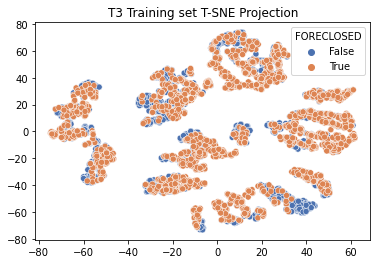

In [154]:
tsne_T=T3
tsne_y=y3
i=3
tsne_title = "T{} Training set T-SNE Projection".format(i)

tsne = TSNE(init='random',learning_rate='auto')
z = tsne.fit_transform(tsne_T) 
tsne1=sns.scatterplot(x=z[:,0], y=z[:,1],hue=y3,
                      palette=sns.color_palette("deep", 2)).set(title=tsne_title) 

## Train Model

In [273]:
def TrainModel(T,y,dfF):  
    df_train, df_test,y_train,y_test = train_test_split(T,y, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)
    clf = LogisticRegression(random_state=0).fit(df_train,y_train)
    score = cross_val_score(clf, df_train, y_train, 
                cv=StratifiedKFold(n_splits=5), 
                scoring='accuracy').mean()
    FC_pred = clf.predict(dfF)
    FC_true_prob = clf.predict_proba(dfF)[:,1]
    return(score,FC_true_prob)

In [274]:
train_dict = {
    "T1":(T1,y1),
    "T2":(T2,y2),
    "T3":(T3,y3),
    "T4":(T4,y4)
}
scores = np.array([])
T_prob_df = pd.DataFrame({'T1':[],
                          'T2':[],
                          'T3':[],
                          'T4':[]})
for name,(T, y) in train_dict.items():
    score,FC_true_prob = TrainModel(T,y,dfF)
    scores = np.append(scores,score)
    T_prob_df[name]= FC_true_prob

In [275]:
scores

array([0.98631968, 0.69735411, 0.69856916, 0.69816683])

## Analyze Scores
The reason for high accuracy using the original sample size is because the proportion of 'False Foreclosed' is too large.
To avoid the problems caused by the imbalance dataset, using model trained from 'T4' instead.

In [276]:
# sorted_FC_prob=sorted(range(len(T_prob_df.T4)),
#                       key = lambda sub: T_prob_df.T4[sub],reverse=True)
T_prob = sorted(T_prob_df.T4,reverse=True)[1000]
FORECLOSED = np.array(T_prob_df.T4>T_prob,dtype='bool')

In [277]:
FORECLOSED_tb = pd.DataFrame({'LID':dfTEST.LID.astype('str'),
                              'FORECLOSED':FORECLOSED})

In [278]:
FORECLOSED_tb.head()

,LID,FORECLOSED
0,794000000000.0,False
1,277000000000.0,False
2,507000000000.0,False
3,493000000000.0,False
4,843000000000.0,False


In [287]:
FORECLOSED_tb.to_csv('FORECLOSURES.csv',index=False)

In [286]:
sum(FORECLOSED_tb.FORECLOSED)

1000